## 라이브러리 및 옵션

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from surprise import Dataset, Reader, accuracy, KNNBasic, SVD, NMF, SlopeOne, CoClustering, BaselineOnly
from surprise.model_selection import cross_validate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler 
from sklearn import model_selection

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 1000)

%matplotlib inline
from matplotlib.colors import LogNorm

## 데이터 불러오기 및 전처리

In [2]:
df=pd.read_csv('./sample3.csv')
df=df.drop('Unnamed: 0',axis=1)
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:23 UTC,view,6200260,2053013552293216471,appliances.environment.air_heater,midea,47.62,538645907,7d9a8784-7b6c-426e-9924-9f688812fd71
1,2019-10-01 00:08:35 UTC,view,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,555448677,3886fcc8-3618-4bb0-a9f4-614bfb2d5263
2,2019-10-01 00:11:37 UTC,view,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,555448864,32f9d470-c71e-46cf-bd3d-0afd1cd961ed
3,2019-10-01 00:14:25 UTC,view,1004870,2053013555631882655,electronics.smartphone,samsung,286.86,555448864,32f9d470-c71e-46cf-bd3d-0afd1cd961ed
4,2019-10-01 00:14:37 UTC,view,1004870,2053013555631882655,electronics.smartphone,samsung,286.86,555448864,32f9d470-c71e-46cf-bd3d-0afd1cd961ed
...,...,...,...,...,...,...,...,...,...
70726,2019-10-04 23:57:09 UTC,view,45600336,2116907524572577889,apparel.shoes,garvalin,69.50,556879445,f33a90d8-ffd1-4174-8fa1-dff866e00657
70727,2019-10-04 23:57:12 UTC,view,1201465,2172371436436455782,electronics.tablet,samsung,238.56,534887795,38022291-a33e-4b8b-a532-70e4e90f0b4b
70728,2019-10-04 23:58:27 UTC,view,1200617,2172371436436455782,electronics.tablet,samsung,128.42,534887795,38022291-a33e-4b8b-a532-70e4e90f0b4b
70729,2019-10-04 23:59:22 UTC,view,1200617,2172371436436455782,electronics.tablet,samsung,128.42,534887795,38022291-a33e-4b8b-a532-70e4e90f0b4b


view -> 1\
cart -> 10\
purchase ->50

In [3]:
df['user_score'] = df['event_type'].map({'view':1,'cart':10,'purchase':50})
df['user_purchase'] = df['event_type'].apply(lambda x: 1 if x=='purchase' else 0)
df['price_category'] = 0
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,user_score,user_purchase,price_category
0,2019-10-01 00:00:23 UTC,view,6200260,2053013552293216471,appliances.environment.air_heater,midea,47.62,538645907,7d9a8784-7b6c-426e-9924-9f688812fd71,1,0,0
1,2019-10-01 00:08:35 UTC,view,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,555448677,3886fcc8-3618-4bb0-a9f4-614bfb2d5263,1,0,0
2,2019-10-01 00:11:37 UTC,view,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,555448864,32f9d470-c71e-46cf-bd3d-0afd1cd961ed,1,0,0
3,2019-10-01 00:14:25 UTC,view,1004870,2053013555631882655,electronics.smartphone,samsung,286.86,555448864,32f9d470-c71e-46cf-bd3d-0afd1cd961ed,1,0,0
4,2019-10-01 00:14:37 UTC,view,1004870,2053013555631882655,electronics.smartphone,samsung,286.86,555448864,32f9d470-c71e-46cf-bd3d-0afd1cd961ed,1,0,0


각 category별 가격 범주 나누기

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70731 entries, 0 to 70730
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event_time      70731 non-null  object 
 1   event_type      70731 non-null  object 
 2   product_id      70731 non-null  int64  
 3   category_id     70731 non-null  int64  
 4   category_code   70731 non-null  object 
 5   brand           70731 non-null  object 
 6   price           70731 non-null  float64
 7   user_id         70731 non-null  int64  
 8   user_session    70731 non-null  object 
 9   user_score      70731 non-null  int64  
 10  user_purchase   70731 non-null  int64  
 11  price_category  70731 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 6.5+ MB


In [5]:
df=df.astype({'price_category':'object'})
for i in df['category_code'].unique():
    df.loc[df['category_code']==i,'price_category'] = pd.qcut(x=df['price'][df['category_code']==i],q=5,labels=False,duplicates='drop')
df.dropna(subset=['price_category'],inplace=True)
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,user_score,user_purchase,price_category
0,2019-10-01 00:00:23 UTC,view,6200260,2053013552293216471,appliances.environment.air_heater,midea,47.62,538645907,7d9a8784-7b6c-426e-9924-9f688812fd71,1,0,3
1,2019-10-01 00:08:35 UTC,view,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,555448677,3886fcc8-3618-4bb0-a9f4-614bfb2d5263,1,0,2
2,2019-10-01 00:11:37 UTC,view,1004767,2053013555631882655,electronics.smartphone,samsung,254.82,555448864,32f9d470-c71e-46cf-bd3d-0afd1cd961ed,1,0,2
3,2019-10-01 00:14:25 UTC,view,1004870,2053013555631882655,electronics.smartphone,samsung,286.86,555448864,32f9d470-c71e-46cf-bd3d-0afd1cd961ed,1,0,2
4,2019-10-01 00:14:37 UTC,view,1004870,2053013555631882655,electronics.smartphone,samsung,286.86,555448864,32f9d470-c71e-46cf-bd3d-0afd1cd961ed,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
70726,2019-10-04 23:57:09 UTC,view,45600336,2116907524572577889,apparel.shoes,garvalin,69.50,556879445,f33a90d8-ffd1-4174-8fa1-dff866e00657,1,0,1
70727,2019-10-04 23:57:12 UTC,view,1201465,2172371436436455782,electronics.tablet,samsung,238.56,534887795,38022291-a33e-4b8b-a532-70e4e90f0b4b,1,0,2
70728,2019-10-04 23:58:27 UTC,view,1200617,2172371436436455782,electronics.tablet,samsung,128.42,534887795,38022291-a33e-4b8b-a532-70e4e90f0b4b,1,0,1
70729,2019-10-04 23:59:22 UTC,view,1200617,2172371436436455782,electronics.tablet,samsung,128.42,534887795,38022291-a33e-4b8b-a532-70e4e90f0b4b,1,0,1


user-product dataframe 만들어주기\
구입을 한 경우 'user_purchase'를 1, 구매하지 않은 경우 0로 설정\
MinMax를 사용하여 'interaction_score'을 만들어줌

In [14]:
group = df.groupby(['user_id','product_id'])['user_score','user_purchase'].sum().reset_index()
group['user_purchase'] = group['user_purchase'].apply(lambda x: 1 if x>1 else x)
group['user_score'] = group['user_score'].apply(lambda x: 100 if x>100 else x)

std = MinMaxScaler(feature_range=(0.025, 1))
std.fit(group['user_score'].values.reshape(-1,1))
group['interaction_score'] = std.transform(group['user_score'].values.reshape(-1,1))
group

,user_id,product_id,user_score,user_purchase,interaction_score
0,241784978,1002544,1,0,0.025000
1,336420903,21406140,2,0,0.034848
2,336420903,21406169,2,0,0.034848
3,336420903,21407286,3,0,0.044697
4,373445245,3701095,2,0,0.034848
...,...,...,...,...,...
39818,556878415,6200514,1,0,0.025000
39819,556878415,6200515,2,0,0.034848
39820,556878415,6200718,2,0,0.034848
39821,556878415,6200724,2,0,0.034848


In [15]:
group = group.merge(df[['product_id','category_code','brand','price','price_category']].drop_duplicates('product_id'),on=['product_id'])
group

,user_id,product_id,user_score,user_purchase,interaction_score,category_code,brand,price,price_category
0,241784978,1002544,1,0,0.025000,electronics.smartphone,apple,464.08,3
1,512413933,1002544,1,0,0.025000,electronics.smartphone,apple,464.08,3
2,512471652,1002544,1,0,0.025000,electronics.smartphone,apple,464.08,3
3,512475147,1002544,2,0,0.034848,electronics.smartphone,apple,464.08,3
4,512500203,1002544,1,0,0.025000,electronics.smartphone,apple,464.08,3
...,...,...,...,...,...,...,...,...,...
39818,556862015,21401593,1,0,0.025000,electronics.clocks,casio,49.94,0
39819,556862015,21403655,1,0,0.025000,electronics.clocks,citizen,616.23,4
39820,556862015,21404354,1,0,0.025000,electronics.clocks,casio,45.30,0
39821,556862015,21405806,3,0,0.044697,electronics.clocks,casio,217.77,2


## EDA

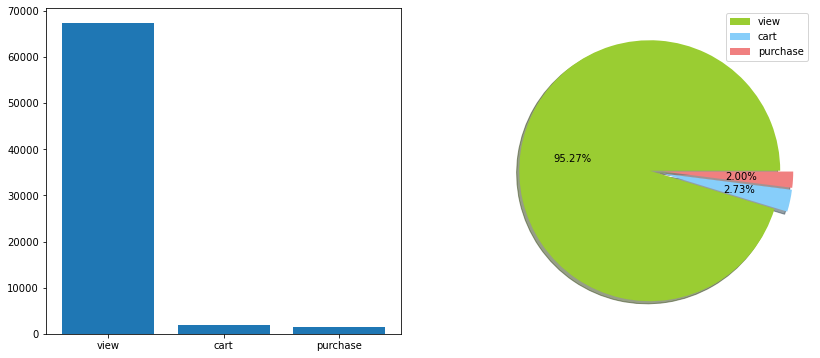

In [8]:
colors = ['yellowgreen', 'lightskyblue','lightcoral']
explode = [0, 0.1,0.1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axes[0].bar(df["event_type"].value_counts().index,df["event_type"].value_counts().values)
axes[1].pie(df["event_type"].value_counts().values, colors = colors, explode = explode, shadow = True, autopct = '%.2f%%')
axes[1].legend(df["event_type"].value_counts().index)

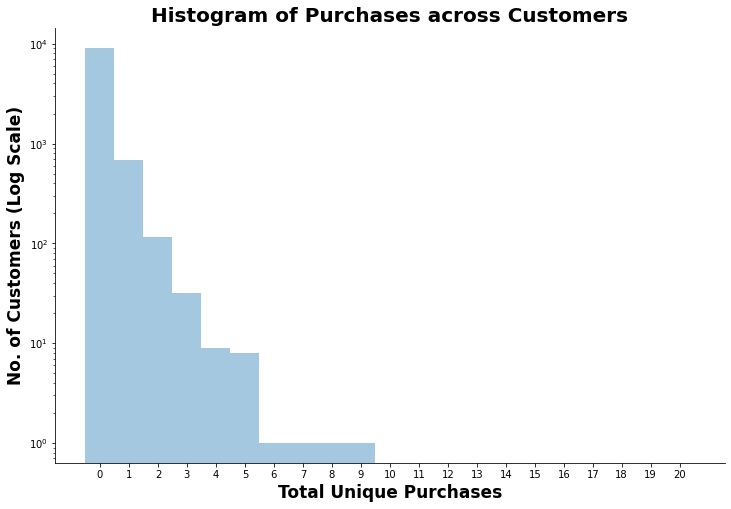

In [9]:
user_group = group.groupby('user_id')['user_purchase'].sum()
user_group = pd.DataFrame(user_group)
user_group.sort_values(by='user_purchase')

fig1 = plt.figure(figsize=[12,8])
ax1 = sns.distplot(user_group,bins=np.arange(22)-0.5,kde=False)
plt.yscale('log')
plt.xticks(range(0,21,1))
plt.ylabel('No. of Customers (Log Scale)',fontsize=17, weight='bold')
plt.xlabel('Total Unique Purchases', fontsize=17, weight='bold')
plt.title('Histogram of Purchases across Customers',weight='bold',fontsize=20)
sns.despine()
plt.savefig('hisplot.png',transparent=True, bbox_inches='tight')

대부분의 고객들이 아무것도 구매하지 않은 것을 확인 할 수 있다.\
이 데이터를 활용한 추천 시스템이 구매를 정확하게 예측하는 것은 어려울 것이라는 신호

##  모델 선택

training set -> 0.6
validation set -> 0.2
test set -> 0.2

In [16]:
X_train_val, X_test = model_selection.train_test_split(group,test_size=0.2, random_state=42)
X_train, X_valid = model_selection.train_test_split(X_train_val,test_size=0.25,random_state=42)
print('X_train_val : ',X_train_val.shape)
print('X_train : ',X_train.shape)
print('X_valid : ',X_valid.shape)
print('X_test : ',X_test.shape)

X_train_val :  (31858, 9)
X_train :  (23893, 9)
X_valid :  (7965, 9)
X_test :  (7965, 9)


In [17]:
X_valid1 = X_valid.copy()
X_valid2 = X_valid.copy()
X_train_val1 = X_train_val.copy()

###  사용할 메트릭스 정리

In [18]:
product_cat = X_train[['product_id','price_category','category_code','brand']].drop_duplicates('product_id')
product_cat = product_cat.sort_values(by='product_id')
product_cat

,product_id,price_category,category_code,brand
31410,1001588,0,electronics.smartphone,meizu
37898,1002042,0,electronics.smartphone,samsung
16189,1002098,2,electronics.smartphone,samsung
9294,1002099,2,electronics.smartphone,samsung
10526,1002100,2,electronics.smartphone,samsung
...,...,...,...,...
27068,52900102,2,accessories.bag,stanley
27069,52900103,2,accessories.bag,stanley
36589,53900007,1,construction.tools.saw,bosch
35866,53900008,2,construction.tools.saw,dewalt


- item category similarity

In [30]:
tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['category_code']))
dt_matrix = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())
cos_similar_matrix = pd.DataFrame(cosine_similarity(dt_matrix.values),columns=product_cat['product_id'],index=product_cat['product_id'])
cos_similar_matrix

product_id,1001588,1002042,1002098,1002099,1002100,1002101,1002102,1002225,1002367,1002396,...,52900072,52900075,52900077,52900084,52900101,52900102,52900103,53900007,53900008,53900009
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002042,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002099,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002100,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52900102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
52900103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
53900007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


- price category similarity

In [53]:
product_cat_matrix = np.reciprocal(euclidean_distances(np.array(product_cat['price_category']).reshape(-1,1))+1)
euclidean_matrix = pd.DataFrame(product_cat_matrix,columns=product_cat['product_id'],index=product_cat['product_id'])
euclidean_matrix

product_id,1001588,1002042,1002098,1002099,1002100,1002101,1002102,1002225,1002367,1002396,...,52900072,52900075,52900077,52900084,52900101,52900102,52900103,53900007,53900008,53900009
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,1.000000,0.5,0.333333,...,0.333333,0.5,0.200000,0.200000,0.200000,0.333333,0.333333,0.5,0.333333,0.333333
1002042,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,1.000000,0.5,0.333333,...,0.333333,0.5,0.200000,0.200000,0.200000,0.333333,0.333333,0.5,0.333333,0.333333
1002098,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,1.000000,0.5,0.333333,0.333333,0.333333,1.000000,1.000000,0.5,1.000000,1.000000
1002099,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,1.000000,0.5,0.333333,0.333333,0.333333,1.000000,1.000000,0.5,1.000000,1.000000
1002100,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,1.000000,0.5,0.333333,0.333333,0.333333,1.000000,1.000000,0.5,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52900102,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,1.000000,0.5,0.333333,0.333333,0.333333,1.000000,1.000000,0.5,1.000000,1.000000
52900103,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,1.000000,0.5,0.333333,0.333333,0.333333,1.000000,1.000000,0.5,1.000000,1.000000
53900007,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,0.500000,...,0.500000,1.0,0.250000,0.250000,0.250000,0.500000,0.500000,1.0,0.500000,0.500000


- brand similarity

In [54]:
tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['brand']))
dt_matrix1 = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], 
                          columns=tfidf_vectorizer.get_feature_names())
dt_matrix1 = dt_matrix1 + 0.01
cos_similar_matrix1 = pd.DataFrame(cosine_similarity(dt_matrix1.values),columns=product_cat['product_id'],
                                   index=product_cat['product_id'])
cos_similar_matrix1

product_id,1001588,1002042,1002098,1002099,1002100,1002101,1002102,1002225,1002367,1002396,...,52900072,52900075,52900077,52900084,52900101,52900102,52900103,53900007,53900008,53900009
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,1.000000,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,1.000000,0.087175,...,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175
1002042,0.087175,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.087175,0.087175,0.087175,...,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175
1002098,0.087175,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.087175,0.087175,0.087175,...,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175
1002099,0.087175,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.087175,0.087175,0.087175,...,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175
1002100,0.087175,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.087175,0.087175,0.087175,...,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52900102,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.087175,0.087175,1.000000
52900103,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.087175,0.087175,1.000000
53900007,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,...,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,0.087175,1.000000,0.087175,0.087175


- User-Item Matrix

In [55]:
X_train_matrix = pd.pivot_table(X_train,values='user_score',index='user_id',columns='product_id')
X_train_matrix=X_train_matrix.fillna(0)
X_train_matrix

product_id,1001588,1002042,1002098,1002099,1002100,1002101,1002102,1002225,1002367,1002396,...,52900072,52900075,52900077,52900084,52900101,52900102,52900103,53900007,53900008,53900009
user_id,,,,,,,,,,,,,,,,,,,,,
241784978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390634364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421816670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
429341347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
430276841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556862843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556866450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556875083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### filtering by item category

(user-item matrix) X (item category similarity)

In [56]:
content_matrix = X_train_matrix.dot(cos_similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix)
content_matrix = std.transform(content_matrix)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train['product_id'].unique()),index=sorted(X_train['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
content_df

,user_id,product_id,predicted_interaction
0,241784978,1001588,0.002597
1,241784978,1002042,0.002597
2,241784978,1002098,0.002597
3,241784978,1002099,0.002597
4,241784978,1002100,0.002597
...,...,...,...
57867363,556879445,52900102,0.000000
57867364,556879445,52900103,0.000000
57867365,556879445,53900007,0.000000
57867366,556879445,53900008,0.000000


In [57]:
X_valid1 = X_valid1.merge(content_df,on=['user_id','product_id'])
X_valid1['predicted_purchase'] = X_valid1['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)
X_valid1

,user_id,product_id,user_score,user_purchase,interaction_score,category_code,brand,price,price_category,predicted_interaction,predicted_purchase
0,539110108,1005019,3,0,0.044697,electronics.smartphone,nokia,101.68,0,0.145455,0
1,540018787,1004659,2,0,0.034848,electronics.smartphone,samsung,787.18,3,0.007792,0
2,539467807,1004785,1,0,0.025000,electronics.smartphone,huawei,278.55,2,0.015584,0
3,540820476,5100855,1,0,0.025000,electronics.clocks,apple,617.52,4,0.003905,0
4,430276841,5800299,1,0,0.025000,electronics.audio.subwoofer,alpine,172.46,4,0.115385,0
...,...,...,...,...,...,...,...,...,...,...,...
5412,547846591,1002522,1,0,0.025000,electronics.smartphone,apple,903.59,3,0.129870,0
5413,533712528,6100243,2,0,0.034848,auto.accessories.radar,playme,146.44,4,0.017458,0
5414,516322316,11600140,1,0,0.025000,computers.desktop,microlab,35.78,0,0.028571,0
5415,512413933,1003705,1,0,0.025000,electronics.smartphone,huawei,192.54,1,0.189610,0


In [58]:
item_precision = precision_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_recall = recall_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_f1 = f1_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
print('precision : ',item_precision)
print('recall : ',item_recall)
print('f1 : ',item_f1)

precision :  0.08196721311475409
recall :  0.06756756756756757
f1 :  0.07407407407407407


###  filtering by item category and price category
(user-item matrix) X (item category similarity) X (price category similarity)

In [59]:
similar_matrix = cos_similar_matrix.multiply(euclidean_matrix)
similar_matrix

product_id,1001588,1002042,1002098,1002099,1002100,1002101,1002102,1002225,1002367,1002396,...,52900072,52900075,52900077,52900084,52900101,52900102,52900103,53900007,53900008,53900009
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,1.000000,0.5,0.333333,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1002042,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,1.000000,0.5,0.333333,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1002098,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1002099,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1002100,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52900102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.0,0.5,0.333333,0.333333,0.333333,1.0,1.0,0.0,0.0,0.0
52900103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.0,0.5,0.333333,0.333333,0.333333,1.0,1.0,0.0,0.0,0.0
53900007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.5,0.5


In [60]:
content_matrix = X_train_matrix.dot(similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix.values)
content_matrix = std.transform(content_matrix.values)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train['product_id'].unique()),index=sorted(X_train['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
content_df

,user_id,product_id,predicted_interaction
0,241784978,1001588,0.001184
1,241784978,1002042,0.001184
2,241784978,1002098,0.001299
3,241784978,1002099,0.001299
4,241784978,1002100,0.001299
...,...,...,...
57867363,556879445,52900102,0.000000
57867364,556879445,52900103,0.000000
57867365,556879445,53900007,0.000000
57867366,556879445,53900008,0.000000


In [61]:
X_valid = X_valid.merge(content_df,on=['user_id','product_id'])
X_valid['predicted_purchase'] = X_valid['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)
X_valid

,user_id,product_id,user_score,user_purchase,interaction_score,category_code,brand,price,price_category,predicted_interaction,predicted_purchase
0,539110108,1005019,3,0,0.044697,electronics.smartphone,nokia,101.68,0,0.260561,0
1,540018787,1004659,2,0,0.034848,electronics.smartphone,samsung,787.18,3,0.004274,0
2,539467807,1004785,1,0,0.025000,electronics.smartphone,huawei,278.55,2,0.006061,0
3,540820476,5100855,1,0,0.025000,electronics.clocks,apple,617.52,4,0.004354,0
4,430276841,5800299,1,0,0.025000,electronics.audio.subwoofer,alpine,172.46,4,0.124395,0
...,...,...,...,...,...,...,...,...,...,...,...
5412,547846591,1002522,1,0,0.025000,electronics.smartphone,apple,903.59,3,0.067155,0
5413,533712528,6100243,2,0,0.034848,auto.accessories.radar,playme,146.44,4,0.014446,0
5414,516322316,11600140,1,0,0.025000,computers.desktop,microlab,35.78,0,0.028571,0
5415,512413933,1003705,1,0,0.025000,electronics.smartphone,huawei,192.54,1,0.189610,0


In [62]:
item_price_precision = precision_score(X_valid['user_purchase'],X_valid['predicted_purchase'])
item_price_recall = recall_score(X_valid['user_purchase'],X_valid['predicted_purchase'])
item_price_f1 = f1_score(X_valid['user_purchase'],X_valid['predicted_purchase'])
print('precision : ',item_price_precision)
print('recall : ',item_price_recall)
print('f1 : ',item_price_f1)

precision :  0.08904109589041095
recall :  0.08783783783783784
f1 :  0.08843537414965986


###  filtering by item category, price category and brand
(user-item matrix) X (item category similarity) X (price category similarity) X (brand similarity)

In [63]:
similar_matrix1 = cos_similar_matrix.multiply(euclidean_matrix).multiply(cos_similar_matrix1)
similar_matrix1

product_id,1001588,1002042,1002098,1002099,1002100,1002101,1002102,1002225,1002367,1002396,...,52900072,52900075,52900077,52900084,52900101,52900102,52900103,53900007,53900008,53900009
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,1.000000,0.087175,0.029058,0.029058,0.029058,0.029058,0.029058,0.087175,0.500000,0.029058,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1002042,0.087175,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.087175,0.043587,0.029058,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1002098,0.029058,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.029058,0.043587,0.087175,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1002099,0.029058,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.029058,0.043587,0.087175,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1002100,0.029058,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.029058,0.043587,0.087175,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52900102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.5,0.333333,0.333333,0.333333,1.0,1.0,0.000000,0.000000,0.000000
52900103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.5,0.333333,0.333333,0.333333,1.0,1.0,0.000000,0.000000,0.000000
53900007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.043587,0.043587


In [64]:
content_matrix = X_train_matrix.dot(similar_matrix1)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix)
content_matrix = std.transform(content_matrix)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train['product_id'].unique()),index=sorted(X_train['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
content_df

,user_id,product_id,predicted_interaction
0,241784978,1001588,0.000410
1,241784978,1002042,0.000114
2,241784978,1002098,0.000113
3,241784978,1002099,0.000113
4,241784978,1002100,0.000113
...,...,...,...
57867363,556879445,52900102,0.000000
57867364,556879445,52900103,0.000000
57867365,556879445,53900007,0.000000
57867366,556879445,53900008,0.000000


In [65]:
X_valid2 = X_valid2.merge(content_df,on=['user_id','product_id'])
X_valid2['predicted_purchase'] = X_valid2['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)
X_valid2

,user_id,product_id,user_score,user_purchase,interaction_score,category_code,brand,price,price_category,predicted_interaction,predicted_purchase
0,539110108,1005019,3,0,0.044697,electronics.smartphone,nokia,101.68,0,0.125964,0
1,540018787,1004659,2,0,0.034848,electronics.smartphone,samsung,787.18,3,0.000373,0
2,539467807,1004785,1,0,0.025000,electronics.smartphone,huawei,278.55,2,0.005469,0
3,540820476,5100855,1,0,0.025000,electronics.clocks,apple,617.52,4,0.006645,0
4,430276841,5800299,1,0,0.025000,electronics.audio.subwoofer,alpine,172.46,4,0.231456,0
...,...,...,...,...,...,...,...,...,...,...,...
5412,547846591,1002522,1,0,0.025000,electronics.smartphone,apple,903.59,3,0.012342,0
5413,533712528,6100243,2,0,0.034848,auto.accessories.radar,playme,146.44,4,0.014436,0
5414,516322316,11600140,1,0,0.025000,computers.desktop,microlab,35.78,0,0.020230,0
5415,512413933,1003705,1,0,0.025000,electronics.smartphone,huawei,192.54,1,0.029341,0


In [66]:
item_price_brand_precision = precision_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
item_price_brand_recall = recall_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
item_price_brand_f1 = f1_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
print('precision : ',item_price_brand_precision)
print('recall : ',item_price_brand_recall)
print('f1 : ',item_price_brand_f1)

precision :  0.06341463414634146
recall :  0.08783783783783784
f1 :  0.0736543909348442


### 비교

In [67]:
model = ['Item-Based','Item/Price-Based','Item/Price/Brand-Based']
scoring = ['f1','precision','recall']
model_name = ['item','item_price','item_price_brand']
model_list = []

for i in model:
    for j in scoring:
        model_dic = {'Model': i,'Scoring':j, 'Score':eval('{0}_{1}'.format(model_name[model.index(i)],j))}
        model_list.append(model_dic)

In [68]:
model_df = pd.DataFrame(model_list)
model_df

,Model,Scoring,Score
0,Item-Based,f1,0.074074
1,Item-Based,precision,0.081967
2,Item-Based,recall,0.067568
3,Item/Price-Based,f1,0.088435
4,Item/Price-Based,precision,0.089041
5,Item/Price-Based,recall,0.087838
6,Item/Price/Brand-Based,f1,0.073654
7,Item/Price/Brand-Based,precision,0.063415
8,Item/Price/Brand-Based,recall,0.087838


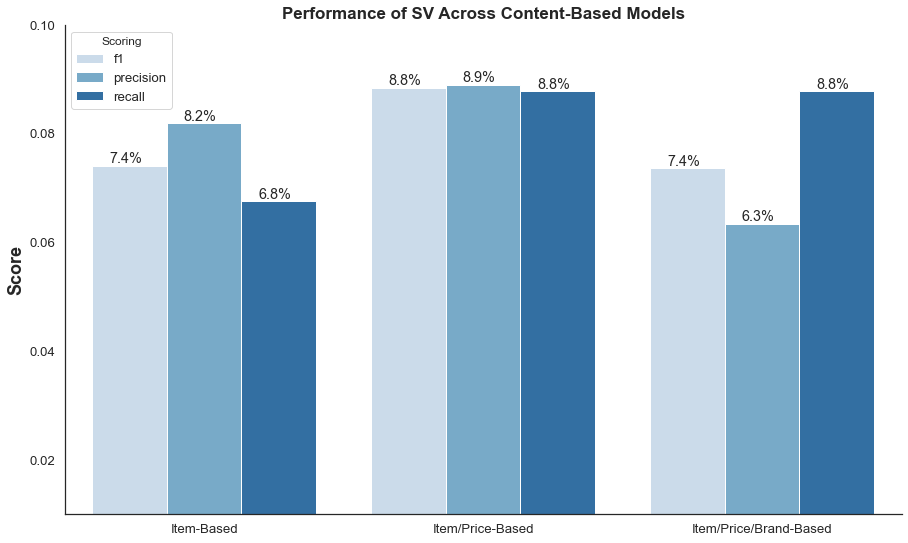

In [69]:
sns.set(style='white',font_scale=1.2)
fig = plt.figure(figsize=(15,9))
ax = sns.barplot(x='Model',y='Score',data=model_df,hue='Scoring',palette='Blues')
for p in ax.patches:
        ax.annotate(str((p.get_height()*100).round(1))+'%', (p.get_x()+0.06, p.get_height()+0.0005))
plt.ylim([0.01,0.10])      
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Performance of SV Across Content-Based Models',weight='bold',fontsize=17)
sns.despine()
plt.savefig('barplot.png',transparent=True, bbox_inches='tight')

## 모델 결정

In [10]:
product_cat = X_train_val1[['product_id','price_category','category_code','brand']].drop_duplicates('product_id')
product_cat = product_cat.sort_values(by='product_id')
product_cat

,product_id,price_category,category_code,brand
31409,1001588,0,electronics.smartphone,meizu
37897,1002042,0,electronics.smartphone,samsung
16186,1002098,2,electronics.smartphone,samsung
9253,1002099,2,electronics.smartphone,samsung
10535,1002100,2,electronics.smartphone,samsung
...,...,...,...,...
27068,52900102,2,accessories.bag,stanley
27069,52900103,2,accessories.bag,stanley
36589,53900007,1,construction.tools.saw,bosch
35867,53900008,2,construction.tools.saw,dewalt


- item category similarity

In [11]:
tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['category_code']))
dt_matrix = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())
cos_similar_matrix = pd.DataFrame(cosine_similarity(dt_matrix.values),columns=product_cat['product_id'],index=product_cat['product_id'])
cos_similar_matrix

product_id,1001588,1002042,1002098,1002099,1002100,1002101,1002102,1002225,1002367,1002396,...,52900077,52900084,52900091,52900097,52900101,52900102,52900103,53900007,53900008,53900009
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002042,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002099,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002100,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52900102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
52900103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
53900007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


- price category similarity

In [12]:
product_cat_matrix = np.reciprocal(euclidean_distances(np.array(product_cat['price_category']).reshape(-1,1))+1)
euclidean_matrix = pd.DataFrame(product_cat_matrix,columns=product_cat['product_id'],index=product_cat['product_id'])
euclidean_matrix

product_id,1001588,1002042,1002098,1002099,1002100,1002101,1002102,1002225,1002367,1002396,...,52900077,52900084,52900091,52900097,52900101,52900102,52900103,53900007,53900008,53900009
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,1.000000,0.5,0.333333,...,0.200000,0.200000,0.333333,0.250000,0.200000,0.333333,0.333333,0.5,0.333333,0.333333
1002042,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,1.000000,0.5,0.333333,...,0.200000,0.200000,0.333333,0.250000,0.200000,0.333333,0.333333,0.5,0.333333,0.333333
1002098,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.333333,0.333333,1.000000,0.500000,0.333333,1.000000,1.000000,0.5,1.000000,1.000000
1002099,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.333333,0.333333,1.000000,0.500000,0.333333,1.000000,1.000000,0.5,1.000000,1.000000
1002100,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.333333,0.333333,1.000000,0.500000,0.333333,1.000000,1.000000,0.5,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52900102,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.333333,0.333333,1.000000,0.500000,0.333333,1.000000,1.000000,0.5,1.000000,1.000000
52900103,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.333333,0.333333,1.000000,0.500000,0.333333,1.000000,1.000000,0.5,1.000000,1.000000
53900007,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,0.500000,...,0.250000,0.250000,0.500000,0.333333,0.250000,0.500000,0.500000,1.0,0.500000,0.500000


- User-Item Matrix

In [13]:
X_train_val_matrix = pd.pivot_table(X_train_val1,values='user_score',index='user_id',columns='product_id')
X_train_val_matrix=X_train_val_matrix.fillna(0)
X_train_val_matrix

product_id,1001588,1002042,1002098,1002099,1002100,1002101,1002102,1002225,1002367,1002396,...,52900077,52900084,52900091,52900097,52900101,52900102,52900103,53900007,53900008,53900009
user_id,,,,,,,,,,,,,,,,,,,,,
241784978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336420903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
373445245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390634364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421816670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556863792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556866450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556875083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
similar_matrix = cos_similar_matrix.multiply(euclidean_matrix)
similar_matrix

product_id,1001588,1002042,1002098,1002099,1002100,1002101,1002102,1002225,1002367,1002396,...,52900077,52900084,52900091,52900097,52900101,52900102,52900103,53900007,53900008,53900009
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,1.000000,0.5,0.333333,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1002042,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,1.000000,0.5,0.333333,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1002098,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1002099,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1002100,0.333333,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.5,1.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52900102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.333333,0.333333,1.0,0.5,0.333333,1.0,1.0,0.0,0.0,0.0
52900103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.333333,0.333333,1.0,0.5,0.333333,1.0,1.0,0.0,0.0,0.0
53900007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.5,0.5


In [15]:
content_matrix = X_train_val_matrix.dot(similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix)
content_matrix = std.transform(content_matrix)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train_val1['product_id'].unique()),index=sorted(X_train_val1['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
content_df

,user_id,product_id,predicted_interaction
0,241784978,1001588,0.000908
1,241784978,1002042,0.000908
2,241784978,1002098,0.001031
3,241784978,1002099,0.001031
4,241784978,1002100,0.001031
...,...,...,...
78106155,556879445,52900102,0.000000
78106156,556879445,52900103,0.000000
78106157,556879445,53900007,0.000000
78106158,556879445,53900008,0.000000


In [16]:
X_test = X_test.merge(content_df,on=['user_id','product_id'])
X_test['predicted_purchase'] = X_test['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)
X_test

,user_id,product_id,user_score,user_purchase,interaction_score,category_code,brand,price,price_category,predicted_interaction,predicted_purchase
0,556000665,4804056,2,0,0.034848,electronics.audio.headphone,apple,161.98,4,0.023333,0
1,555689866,1004720,1,0,0.025000,electronics.smartphone,huawei,130.62,0,0.127972,0
2,517857415,4700157,1,0,0.025000,auto.accessories.videoregister,neoline,282.83,4,0.061848,0
3,551125867,28300262,1,0,0.025000,accessories.wallet,karya,29.60,0,0.049343,0
4,525711897,1307336,1,0,0.025000,computers.notebook,asus,357.25,1,0.003632,0
...,...,...,...,...,...,...,...,...,...,...,...
5877,543593508,3000063,1,0,0.025000,appliances.kitchen.steam_cooker,braun,100.36,3,0.011906,0
5878,530191018,1004767,3,0,0.044697,electronics.smartphone,samsung,254.82,2,0.006186,0
5879,514310072,1005135,2,0,0.034848,electronics.smartphone,apple,1747.79,4,0.231618,0
5880,555699879,12201985,1,0,0.025000,sport.bicycle,cube,452.78,3,0.125000,0


In [17]:
precision = precision_score(X_test['user_purchase'],X_test['predicted_purchase'])
recall = recall_score(X_test['user_purchase'],X_test['predicted_purchase'])
f1 = f1_score(X_test['user_purchase'],X_test['predicted_purchase'])
print('precision : ',precision)
print('recall : ',recall)
print('f1 : ',f1)

precision :  0.07537688442211055
recall :  0.09259259259259259
f1 :  0.08310249307479224


## 모델 평가

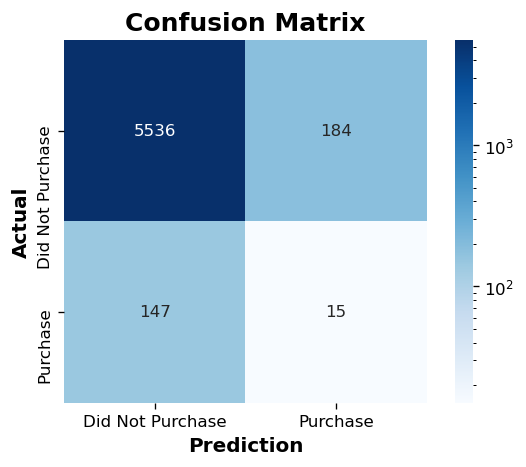

In [18]:
satisfaction_confusion = confusion_matrix(X_test['user_purchase'], X_test['predicted_purchase'])
plt.figure(dpi=120)
ax = sns.heatmap(satisfaction_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',norm=LogNorm(),
xticklabels=['Did Not Purchase', 'Purchase'],
yticklabels=['Did Not Purchase', 'Purchase']);   
plt.xlabel('Prediction',weight='bold',fontsize=12)
plt.ylabel('Actual',weight='bold',fontsize=12)
plt.title('Confusion Matrix',weight='bold',fontsize=15)
plt.savefig('confusionmatrix.png',transparent=True, bbox_inches='tight')

In [19]:
user_purchase = []
for i in range(1,6):
    X_sub = X_test[X_test['user_id'].isin(list(X_test.groupby('user_id')['user_purchase'].sum().reset_index()[X_test.groupby('user_id')['user_purchase'].sum().reset_index()['user_purchase']==i]['user_id']))]
    recall = recall_score(X_sub['user_purchase'],X_sub['predicted_purchase'])
    precision = precision_score(X_sub['user_purchase'],X_sub['predicted_purchase'])
    user_purchase.append({'No. of Purchase':i,'Recall':recall,'Precision':precision})

In [20]:
user_purchase = pd.DataFrame(user_purchase)
user_purchase2 = user_purchase.stack().reset_index().rename(columns={'level_0':'No. of Purchase','level_1':'Metric', 0:'Score'})[user_purchase.stack().reset_index().rename(columns={'level_0':'No. of Purchase','level_1':'Metric', 0:'Score'})['Metric']!='No. of Purchase']
user_purchase2['No. of Purchase'] = user_purchase2['No. of Purchase'].apply(lambda x:x+1)
user_purchase2

,No. of Purchase,Metric,Score
1,1,Recall,0.053030
2,1,Precision,0.350000
4,2,Recall,0.222222
5,2,Precision,0.666667
7,3,Recall,0.333333
8,3,Precision,0.500000
10,4,Recall,0.000000
11,4,Precision,0.000000
13,5,Recall,0.000000
14,5,Precision,0.000000


In [21]:
user_group = X_test.groupby('user_id')['user_purchase'].sum()
user_group = pd.DataFrame(user_group)
user_group.sort_values(by='user_purchase')

,user_purchase
user_id,
430276841,0
542678426,0
542680553,0
542692117,0
542694781,0
...,...
523685364,2
535234446,3
555561884,3


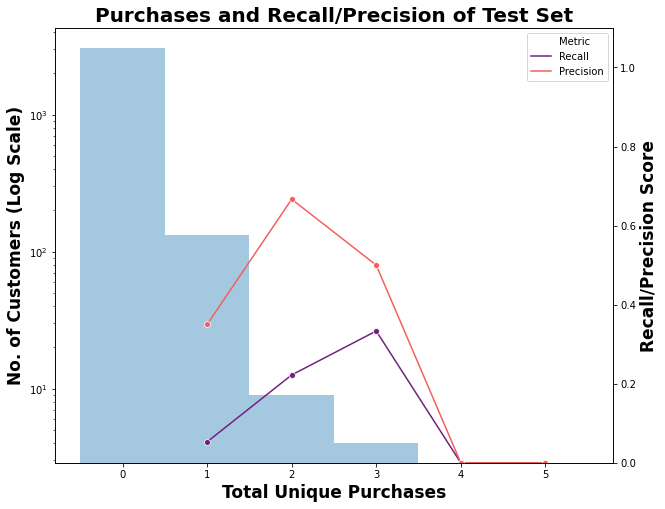

In [22]:
fig1 = plt.figure(figsize=[10,8])
ax1 = sns.distplot(user_group,bins=np.arange(7)-0.5,kde=False)
plt.yscale('log')
plt.xticks(range(0,6,1))
plt.ylabel('No. of Customers (Log Scale)',fontsize=17, weight='bold')
plt.xlabel('Total Unique Purchases', fontsize=17, weight='bold')
ax2 = plt.twinx()
sns.lineplot(x='No. of Purchase',y='Score',data=user_purchase2, hue='Metric',ax=ax2,marker='o',sort=False,palette='magma')
plt.ylim([0,1.1])
plt.ylabel('Recall/Precision Score',fontsize=17,weight='bold') 
plt.title('Purchases and Recall/Precision of Test Set',weight='bold',fontsize=20)
plt.savefig('mixplot.png',transparent=True, bbox_inches='tight')

모델의 정밀도는 실제로 한 번 이상 구매한 고객의 경우 훨씬 더 높다.<br>
이는 도레이 구매 고객에게 추천할 때 고객이 실제로 제품을 선택할 것이라고 더 확신할 수 있음을 의미한다.<br>
따라서 전체 정밀도는 결국 구매하지 않은 고객의 예측된 구매에 대한 오탐으로 인해 저하된다.<br>
더 많이 제품을 구매한 고객일수록 precision과 recall이 더 높은 것을 확인할 수 있다.<br>
이는 모델의 성능을 측정하는 방법이 구매 고객에게 더 편향되어 있기 때문일 수 있다.

## 모델 시연

In [23]:
sample_user=random.sample(X_test['user_id'].unique().tolist(),1)[0]
sample_user

512624529

In [24]:
sample_user=527910877

In [25]:
sampleuser_train = X_train[X_train['user_id']==sample_user]
sampleuser_train

,user_id,product_id,user_score,user_purchase,interaction_score,category_code,brand,price,price_category
2046,527910877,3600661,88,1,0.881818,appliances.kitchen.washer,samsung,295.49,2
9785,527910877,2701646,3,0,0.044697,appliances.kitchen.refrigerators,indesit,270.02,1
21256,527910877,1801690,83,1,0.832576,electronics.video.tv,samsung,368.04,2
20446,527910877,2701657,1,0,0.025000,appliances.kitchen.refrigerators,beko,257.04,1
30307,527910877,3601505,1,0,0.025000,appliances.kitchen.washer,samsung,463.15,4
9764,527910877,2700609,71,1,0.714394,appliances.kitchen.refrigerators,indesit,310.37,2
22907,527910877,2700239,4,0,0.054545,appliances.kitchen.refrigerators,atlant,283.12,2


In [30]:
a=sampleuser_train['product_id'].tolist()
a.append(2701639)
a

[3600661, 2701646, 1801690, 2701657, 3601505, 2700609, 2700239, 2701639]

In [26]:
sampleuser_test = X_test[X_test['user_id']==sample_user]
sampleuser_test

,user_id,product_id,user_score,user_purchase,interaction_score,category_code,brand,price,price_category,predicted_interaction,predicted_purchase
2060,527910877,2701639,2,0,0.034848,appliances.kitchen.refrigerators,indesit,257.15,1,0.633626,1


In [27]:
sample = content_df[content_df['user_id']==sample_user].sort_values(by='predicted_interaction',ascending=False).merge(group[['product_id','category_code','brand','price','price_category']].drop_duplicates('product_id'),on='product_id')
sample.head(10)

,user_id,product_id,predicted_interaction,category_code,brand,price,price_category
0,527910877,2800103,1.0,appliances.kitchen.refrigerators,midea,288.30,2
1,527910877,3200286,1.0,appliances.kitchen.meat_grinder,polaris,74.11,2
2,527910877,2800636,1.0,appliances.kitchen.refrigerators,indesit,324.08,2
3,527910877,2900634,1.0,appliances.kitchen.oven,elenberg,97.79,2
4,527910877,3200013,1.0,appliances.kitchen.meat_grinder,panasonic,101.65,2
5,527910877,3200031,1.0,appliances.kitchen.meat_grinder,panasonic,76.94,2
6,527910877,6300680,1.0,appliances.kitchen.kettle,redmond,33.44,2
7,527910877,3200154,1.0,appliances.kitchen.meat_grinder,polaris,64.33,2
8,527910877,6300658,1.0,appliances.kitchen.kettle,maxwell,38.35,2
9,527910877,3200280,1.0,appliances.kitchen.meat_grinder,moulinex,66.90,2


In [36]:
sample.loc[135:145].reset_index(drop=True)

,user_id,product_id,predicted_interaction,category_code,brand,price,price_category
0,527910877,2700283,1.0,appliances.kitchen.refrigerators,pozis,295.99,2
1,527910877,2700323,1.0,appliances.kitchen.refrigerators,atlant,282.89,2
2,527910877,2700360,1.0,appliances.kitchen.refrigerators,atlant,351.36,2
3,527910877,2700517,1.0,appliances.kitchen.refrigerators,atlant,297.82,2
4,527910877,2700588,1.0,appliances.kitchen.refrigerators,indesit,295.99,2
5,527910877,2700598,1.0,appliances.kitchen.refrigerators,indesit,330.97,2
6,527910877,2700609,1.0,appliances.kitchen.refrigerators,indesit,310.37,2
7,527910877,2700611,1.0,appliances.kitchen.refrigerators,indesit,333.86,2
8,527910877,2402570,1.0,appliances.kitchen.hood,bosch,102.94,2
9,527910877,2700616,1.0,appliances.kitchen.refrigerators,indesit,334.60,2


In [25]:
recommend_product=sample[['product_id','category_code','brand','price']].head(10)
recommend_product

,product_id,category_code,brand,price
0,2800103,appliances.kitchen.refrigerators,midea,288.30
1,3200286,appliances.kitchen.meat_grinder,polaris,74.11
2,2800636,appliances.kitchen.refrigerators,indesit,324.08
3,2900634,appliances.kitchen.oven,elenberg,97.79
4,3200013,appliances.kitchen.meat_grinder,panasonic,101.65
5,3200031,appliances.kitchen.meat_grinder,panasonic,76.94
6,6300680,appliances.kitchen.kettle,redmond,33.44
7,3200154,appliances.kitchen.meat_grinder,polaris,64.33
8,6300658,appliances.kitchen.kettle,maxwell,38.35
9,3200280,appliances.kitchen.meat_grinder,moulinex,66.90


In [26]:
recommend_product.to_csv('./recommend.csv',index=False)